# Data Collection and Processing
This part of the program is for downloading from the Reddit API and extracting the sentiment scores. The process takes a very long time to complete (about 1 hour for me). I have provided the dataset used in the regression, so there is no need to run this portion of the program. Feel free to examine the code, but please run the Data Analysis code which uses pre-downloaded datasets.

import praw # Reddit API<br>
from transformers import AutoTokenizer, AutoModelForSequenceClassification # for NLP model from huggingface<br>
from scipy.special import softmax<br>
import numpy as np<br>
import pandas as pd<br>
from datetime import datetime<br>

### Download NLP Model
roberta = 'cardiffnlp/twitter-roberta-base-sentiment-latest'<br>
model = AutoModelForSequenceClassification.from_pretrained(roberta)<br>
tokenizer = AutoTokenizer.from_pretrained(roberta)<br>

filepath = "C:/Users/kevin/OneDrive/Documents/FIN 6368.001/Individual Project/StockSymbols.txt"<br>
SP500 = pd.read_csv(filepath, sep='\t', index_col=0)<br>
tickers = '$'+SP500.Symbol<br>
start_date = datetime(2020, 1, 1)<br>
end_date = datetime(2023, 12, 31)<br>
data = []<br>
labels = [-1, 0, 1]<br>

#### Reddit API
reddit = praw.Reddit(<br>
    client_id="aAe3lf50snfF0BmtqliG4Q",<br>
    client_secret="mGfhuP5sv-ILxB4MQBHeElMGzJvtoQ",<br>
    user_agent="Extreme-Feed-4107"<br>
)<br>
subreddit = reddit.subreddit("stocks+investing+StockMarket+wallstreetbets")<br>
#subreddit = reddit.subreddit("all")<br>

#### Search Stocks on Reddit, download data, and calculate sentiment score
for ticker in tickers[0:101]:<br>
    for submission in subreddit.search(ticker, sort = 'relevance', limit=None):<br>
        submission_date = datetime.utcfromtimestamp(submission.created_utc)<br>
        if start_date <= submission_date <= end_date:<br>
            encoded_post = tokenizer(submission.title+submission.selftext,truncation=True,max_length = 512,return_tensors = "pt")<br>
            output = model(**encoded_post)<br>
            score = output[0][0].detach().numpy()<br>
            score = softmax(score)<br>
            data.append((ticker, submission_date, submission.title, np.average(labels, weights=score), submission.url))<br>

#### Export to Excel
posts = pd.DataFrame(data, columns=['ticker','date','title','scores','url'])<br>
#posts = posts.sort_values(by='ticker')<br>
posts.drop_duplicates().dropna()<br>
posts.to_excel('top100_posts.xlsx', index = False)<br>

# Data Analysis
This program is created to analyze and visualize sentiment data collected from the Data Collection. Please view Tableau Storybook for full analysis and additional visualizations.

In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

In [2]:
filepath = "StockSymbols.txt"
SP500 = pd.read_csv(filepath, sep='\t', index_col=0)
tickers = SP500.Symbol[0:101]
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)

In [3]:
#Stock Returns
stockdata = yf.download(list(tickers),start_date,end_date)
stockclose = stockdata.Close.pct_change(periods=1)*100 #daily return
stockreturn = pd.DataFrame()
syms = []
for ticker in tickers:
    stockreturn = pd.concat([stockreturn,stockclose[ticker]], axis = 0)
    syms = syms[:]+[ticker]*len(stockclose[ticker])
stockreturn = stockreturn.reset_index()
syms = pd.Series(syms,index=None)
stockreturn = pd.concat([syms,stockreturn],axis=1)
stockreturn.columns = ['stock','date','return']

#Convert to monthly returns
monthly_return = stockreturn.groupby(['stock',stockreturn['date'].dt.to_period('M')])['return'].sum().reset_index()

[*********************100%%**********************]  101 of 101 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [4]:
#Import Sentiment Scores
sentiment = pd.read_excel('top100_posts.xlsx').drop_duplicates().dropna()
sentiment = pd.concat([sentiment.ticker,sentiment.date,sentiment.scores], axis=1)
monthly_sentiment = sentiment.groupby(['ticker',sentiment['date'].dt.to_period('M')])['scores'].mean().reset_index()
monthly_sentiment.set_index('date',inplace=True)
monthly_sum = sentiment.groupby(['ticker',sentiment['date'].dt.to_period('M')])['scores'].sum().reset_index() #Totals sentiment score by month

## Survey Sentiment Calculation and Data Processing
The survey data comes from the American Association of Individual Investors (AAII) Sentiment Survey which is conducted on a weekly basis. Members of AAII simply provide their opinion on whether the market is Bullish, Neutral, or Bearish and the percentage of voters in each respective category is recorded. 
   
Similar to how the social media sentiment score was calculated, the survey sentiment score associates -1  with a negative outlook, 0 with neutral, and +1 with positive. Using the survey percentages as weights, the weighted average is calculated and used as an index for that period.

In order to make the social media and survey sentiment scores comparable, several adjustments needed to be made to the datasets. First and foremost, the survey sentiment is in reference to the entire stock market. In the social media sentiment dataset, the dataframe is formatted as panel data (by stock and date). In order to convert the stock specific panel data into market data, I had to weight the scores of each stock by market cap percentage (market cap/total market cap). From that point, I iterated through the dataframe and calculated the weighted sum of scores for each month, resulting in a dataframe with 48 entries (one per month). Since the survey data has entries on a weekly basis, simply taking the mean score for each month was sufficient in processing the raw data.
## Social Media vs. Survey Sentiment
When comparing summary statistics between social media sentiment and survey sentiment, there are a few key similarities and differences worth highlighting. Firstly, both sentiment scores tend to center around neutral market conditions (mean close to 0) from 2020-01-01 to 2023-12-31. The survey sentiment is notably more volatile than the social media sentiment (standard deviation of 0.17 vs 0.06) and has a much more dynamic range (over twice the range of social media sentiment). Additionally, the survey sentiment appears to be exhibiting a cyclical pattern. In contrast, the social media sentiment seems to be more random and centered around its mean.

C:\Users\kevin\AppData\Local\Temp\ipykernel_19272\2751399099.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_sentiment['scores'].loc[i] = weighted_sentiment['scores'].loc[i]*capweights['weights'].loc[t]


,Social Media Scores,Survey Scores
count,48.000000,48.000000
mean,0.072803,0.035216
std,0.058977,0.170795
min,-0.065004,-0.279714
25%,0.042717,-0.114659
50%,0.083258,0.055798
75%,0.105963,0.165674
max,0.208437,0.335110
skews,-0.275508,-0.167724
kurts,0.278962,-1.093962


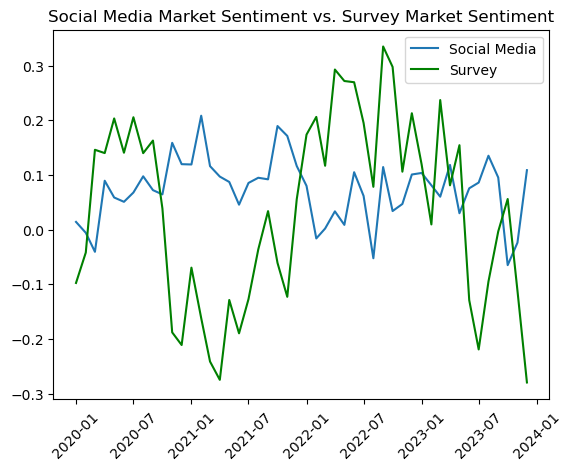

In [5]:
#Import AAII Market Sentiment Survey Results
survey = pd.read_excel('sentiment_survey.xlsx', header = 3, usecols='A:D',nrows = 1909)
survey['Date'] = pd.to_datetime(survey['Date'])
survey = survey[survey['Date']>=start_date]
survey = survey[survey['Date']<=end_date].reset_index()
survey_data = {}
for i in range(len(survey)-1):
    survey_data.setdefault('date',[]).append(survey['Date'].loc[i])
    survey_data.setdefault('scores',[]).append(([-1,1]*survey[['Bullish','Bearish']].loc[i]).sum())
survey_scores = pd.DataFrame(survey_data)
survey_scores['date'] = pd.to_datetime(survey_scores['date'])
survey_scores.set_index('date',inplace=True)
survey_scores = survey_scores.resample('M').mean()
survey_scores.index = survey_scores.index.strftime('%Y-%m')

#Calculate Weights by Market Cap
marketcaps = {}
for ticker in tickers:
    marketcaps.setdefault('stocks',[]).append(ticker)
    try:
        marketstring = SP500[SP500['Symbol']==ticker]['MarketCap'].values[0]
        marketstring = marketstring.replace(',','').replace('B','0000000').replace('.','')
        marketcaps.setdefault('market cap',[]).append(int(marketstring))
    except:
        marketcaps.setdefault('market cap',[]).append(0)      
weights = []
for i in range(len(marketcaps['market cap'])):
    weights.append(marketcaps['market cap'][i]/np.sum(marketcaps['market cap']))
capweights = pd.DataFrame({'stock':tickers,'weights':weights})

#Calculate Market Sentiment from Social Media Data
weighted_sentiment = monthly_sentiment.reset_index()
for i in weighted_sentiment.index:
    for t in capweights.index:
        if weighted_sentiment['ticker'][i] == '$'+capweights['stock'][t]:
            weighted_sentiment['scores'].loc[i] = weighted_sentiment['scores'].loc[i]*capweights['weights'].loc[t]
            
market_data = {}
date_range = pd.date_range(start=start_date,end=end_date,freq='M').strftime('%Y-%m')
for date in date_range:
    market_data.setdefault('date',[]).append(date)
    market_data.setdefault('scores',[]).append(weighted_sentiment[weighted_sentiment['date']==date]['scores'].sum())
market_scores = pd.DataFrame(market_data['scores'],index=market_data['date'],columns=['scores'])

#Summary Statistics
def sumstats(dat):
    df = pd.DataFrame(dat)
    df = df.dropna()  # Drop missing values
    sumstats = df.describe()
    skew = df.skew().rename('skews')  # Rename for concatenation
    kurt = df.kurt().rename('kurts')  # Rename for concatenation
    sumstats_all = pd.concat([sumstats, skew.to_frame().T, kurt.to_frame().T],axis=0)
    return sumstats_all
combined_scores = pd.DataFrame([market_scores['scores'],survey_scores['scores']]).T
combined_scores.columns = ['Social Media Scores','Survey Scores']

sumstats = sumstats(combined_scores)
display(sumstats)
#Plot Social Media Sentiment vs. Survey Sentiment
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(date_range),market_scores['scores'],label='Social Media')
ax.plot(pd.to_datetime(date_range),survey_scores['scores'],label='Survey',color='g')
plt.xticks(rotation=45)
ax.legend()
plt.title('Social Media Market Sentiment vs. Survey Market Sentiment')
plt.show

#Export
#combined_scores.to_excel('social media_vs_survey.xlsx', index = True)
#sumstats.to_excel('sumstats_scores.xlsx', index = True)

In [9]:
#Download Fama-French Factors
data_source = 'famafrench'
factors = web.DataReader('F-F_Research_Data_Factors', data_source, start_date, end_date)[0]
factors.rename(columns={'Mkt-RF':'MKT'},inplace=True)

#Merge Return, Sentiment, and Factor Data
merged = pd.merge(monthly_return, monthly_sum, on='date',how='inner')
mergeddata = []
for i in range(len(merged)-1):
    if '$' + merged['stock'][i] == merged['ticker'][i]:
        mergeddata.append(merged.iloc[i])
merged_data = pd.DataFrame(mergeddata)
merged_data = merged_data.drop(columns=['ticker'])
merged_data = merged_data.sort_values(by=['stock','date'])
merged_data.index = merged_data['date']
merged_data.drop(columns='date')

for date in merged_data.index:
    new_cols = factors[factors.index==date]
    merged_data.loc[date, new_cols.columns] = new_cols
merged_data.index = range(len(merged_data))
merged_data.insert(loc=3, column='excess_return', value=merged_data['return']-merged_data['RF'])
display(merged_data)

#Isolate Training and Testing Data
training_data = merged_data[merged_data['date']<'2023-01']
test_data = merged_data[merged_data['date']>'2022-12']

C:\Users\kevin\AppData\Local\Temp\ipykernel_19272\3073273741.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = web.DataReader('F-F_Research_Data_Factors', data_source, start_date, end_date)[0]
C:\Users\kevin\AppData\Local\Temp\ipykernel_19272\3073273741.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = web.DataReader('F-F_Research_Data_Factors', data_source, start_date, end_date)[0]


,stock,date,return,excess_return,scores,MKT,SMB,HML,RF
0,AAPL,2020-01,3.305911,3.175911,-1.411905,-0.11,-3.11,-6.25,0.13
1,AAPL,2020-02,-11.840414,-11.960414,0.576714,-8.13,1.07,-3.81,0.12
2,AAPL,2020-03,-2.775254,-2.905254,-0.476280,-13.39,-4.83,-13.87,0.13
3,AAPL,2020-04,15.411400,15.411400,0.154236,13.65,2.45,-1.33,0.00
4,AAPL,2020-05,8.048592,8.038592,0.344535,5.58,2.47,-4.88,0.01
...,...,...,...,...,...,...,...,...,...
3915,XOM,2023-05,-14.337016,-14.697016,-0.327480,0.35,1.61,-7.72,0.36
3916,XOM,2023-06,4.992044,4.592044,0.274154,6.46,1.54,-0.26,0.40
3917,XOM,2023-07,0.246256,-0.203744,0.691526,3.21,2.08,4.11,0.45
3918,XOM,2023-09,5.795900,5.365900,0.503464,-5.24,-2.51,1.52,0.43


# Regression Analysis
In this section, we will be running the following 3 regressions: 
1) Social media sentiment scores on Excess returns
2) Fama-French 3 factor model
3) Fama-French 3 factor model + Sentiment scores

The Fama-French 3 factor model will be used as a benchmark to compare with the sentiment analysis model. Additionally, by supplementing Fama-French with the sentiment data, we can find the marginal effect of social media sentiment on stock returns.

In [10]:
#Regress Sentiment Score on Returns
s_lm = smf.ols('training_data["excess_return"] ~ scores', data = training_data).fit()
print(s_lm.summary())
anova_results = sm.stats.anova_lm(s_lm)
print('----------------------------')
print('ANOVA result:')
print(anova_results)
print('----------------------------\n')

#Fama-French 3 Factor Model
ff_lm = smf.ols('training_data["excess_return"] ~ MKT+SMB+HML', data = training_data).fit()
print(ff_lm.summary())
anova_results = sm.stats.anova_lm(ff_lm)
print('----------------------------')
print('ANOVA result:')
print(anova_results)
print('----------------------------\n')

#Fama-French + Sentiment Score
ffs_lm = smf.ols('training_data["excess_return"] ~ MKT+SMB+HML+scores', data = training_data).fit()
print(ffs_lm.summary())
anova_results = sm.stats.anova_lm(ffs_lm)
print('----------------------------')
print('ANOVA result:')
print(anova_results)
print('----------------------------\n')

                                  OLS Regression Results                                  
Dep. Variable:     training_data["excess_return"]   R-squared:                       0.008
Model:                                        OLS   Adj. R-squared:                  0.008
Method:                             Least Squares   F-statistic:                     23.99
Date:                            Thu, 07 Mar 2024   Prob (F-statistic):           1.02e-06
Time:                                    15:50:23   Log-Likelihood:                -10670.
No. Observations:                            2925   AIC:                         2.134e+04
Df Residuals:                                2923   BIC:                         2.136e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

# Regression Prediction
Use previous regression coefficients to predict stock return over the next year and compare with test data.

Sentiment Sum of Squared Errors:
64682.92475146284
Fama-French Sum of Squared Errors:
49815.91980298406
Fama-French + Sentiment Sum of Squared Errors:
49383.304495826225


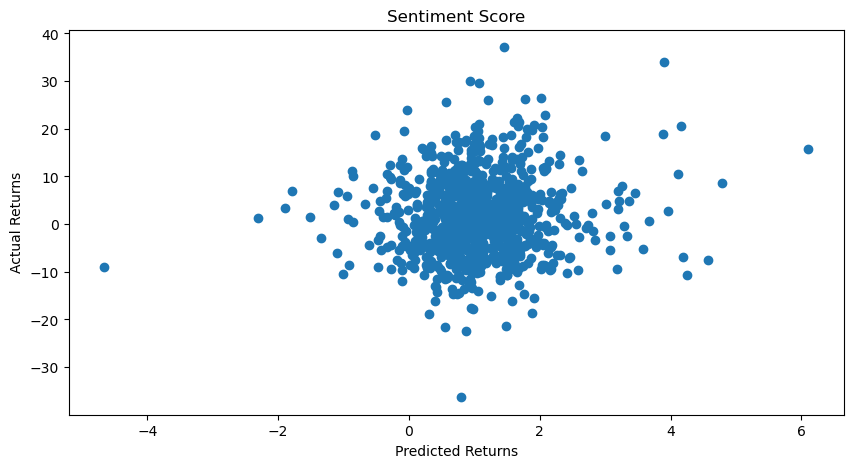

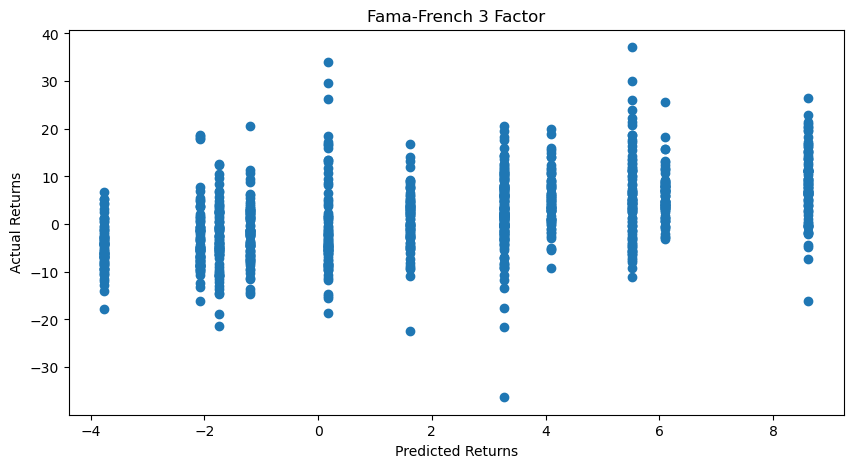

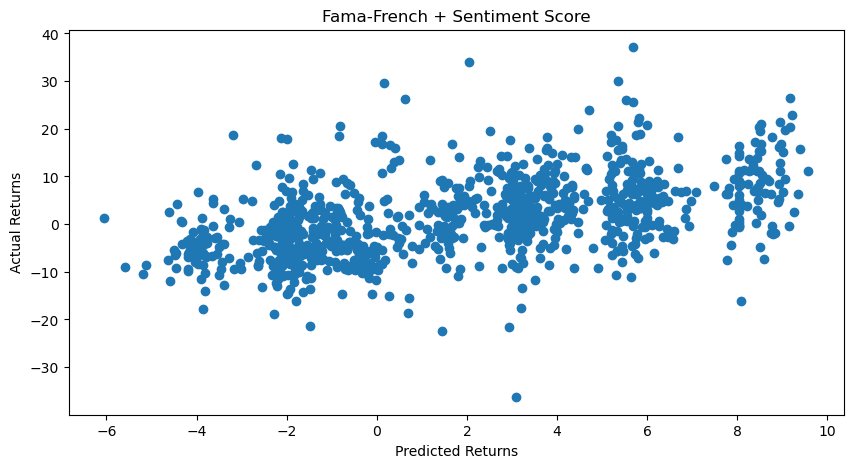

In [11]:
#Sentiment Score on Returns
s_pred = s_lm.predict(test_data)
s_error = s_pred - test_data['excess_return']
plt.figure(figsize=(10,5))
plt.title('Sentiment Score')
plt.xlabel('Predicted Returns')
plt.ylabel('Actual Returns')
plt.scatter(s_pred,test_data['excess_return'])

#Fama-French 3 Factor Model
ff_pred = ff_lm.predict(test_data)
ff_error = ff_pred - test_data['excess_return']
plt.figure(figsize=(10,5))
plt.title('Fama-French 3 Factor')
plt.xlabel('Predicted Returns')
plt.ylabel('Actual Returns')
plt.scatter(ff_pred,test_data['excess_return'])

#Fama-French + Sentiment Score
ffs_pred = ffs_lm.predict(test_data)
ffs_error = ffs_pred - test_data['excess_return']
plt.figure(figsize=(10,5))
plt.title('Fama-French + Sentiment Score')
plt.xlabel('Predicted Returns')
plt.ylabel('Actual Returns')
plt.scatter(ffs_pred,test_data['excess_return'])

#Combine and export Predictions
predictions = pd.DataFrame([test_data['stock'],s_pred,ff_pred,ffs_pred,test_data['excess_return']]).T
predictions.columns=['Stock','S','FF','FFS','Actual']
#predictions.to_excel('predictions.xlsx', index = False)

#Prediction Errors
print('Sentiment Sum of Squared Errors:')
print(sum(s_error*s_error))
print('Fama-French Sum of Squared Errors:')
print(sum(ff_error*ff_error))
print('Fama-French + Sentiment Sum of Squared Errors:')
print(sum(ffs_error*ffs_error))